In [1]:
%matplotlib inline

from pathlib import Path
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,PowerNorm
from matplotlib.patches import Circle
import numpy as np
from numpy.linalg import svd
import imageio
from scipy import ndimage

import stempy.io as stio
import stempy.image as stim

# Set up Cori paths
ncemhub = Path('/global/cfs/cdirs/ncemhub/4Dcamera/')
scratch = Path('/global/cscratch1/sd/percius/')
hdd1 = Path('/mnt/hdd1') # mothership 6
distiller_path = Path('/global/cfs/projectdirs/ncemhub/distiller/')

In [2]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.

    """

    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T) # Could also use np.cov(x) here.
    return ctr, svd(M)[0][:,-1]

# Load the vacuum scan data set

In [3]:
# Close all previous windows to avoid too many windows
plt.close('all')

# Load a sparse vacuum 4D camera data set 
scan_num = 156
threshold = 4.5
# data_dir = Path('2021.10.01')
scan_id = 0
# data_dir = Path('2021.10.01')

fname = Path('/mnt/nvme1/percius/sparse_Si/data_scan{}_th{}_electrons.h5'.format(scan_num, threshold))

# Load the data
vacuum_scan = stio.SparseArray.from_hdf5(fname)

print('Temporary fix for low SNR vacuum scans')
# Remove the flyback
vacuum_scan = vacuum_scan[:,:-1,:,:]
# Bin the scans
# vacuum_scan = vacuum_scan.bin_scans(8)

# Calculate number of electrons per pattern
num_elec = 0
for ii in vacuum_scan.data:
    num_elec += len(ii)
avg_elec = num_elec / vacuum_scan.data.shape[0]

print('File: {}'.format(fname))
print('Initial scan dimensions = {}'.format(vacuum_scan.scan_shape))
print('Mean electrons per pattern: {}'.format(avg_elec))


Temporary fix for low SNR vacuum scans
File: /mnt/nvme1/percius/sparse_Si/data_scan156_th4.5_electrons.h5
Initial scan dimensions = (128, 128)
Mean electrons per pattern: 1.0


# Find the center of the center beam at each scan position

Initial center = [[289.78914842]
 [285.47494629]]


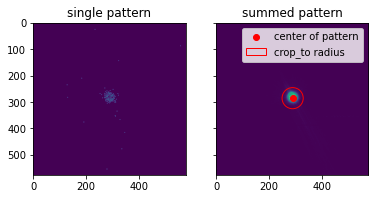

In [4]:
# Calculate the summed diffraction pattern to set hyperparameters
dp = vacuum_scan.sum(axis=(0, 1))

# Get a single dense diffraction pattern
dp0 = vacuum_scan[10, 10, :, :]

# Set the center of the pattern (use figure below for manual)
center = stim.com_dense(dp)
# center = (270, 285) # manually define as column, row from plot (if automated technique fails)
print(f'Initial center = {center}')

# Define the radius for iterative processing
radius = 40 # pixels

fg,ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[1].imshow(dp, norm=PowerNorm(0.75))
ax[1].scatter(center[0], center[1], c='r')
ax[1].add_patch(Circle(center, radius=radius, fc=None, fill=None, ec='r'))
ax[0].imshow(dp0, norm=PowerNorm(0.75))
ax[0].set(title='single pattern')
ax[1].set(title='summed pattern')
ax[1].legend(['center of pattern', 'crop_to radius'])

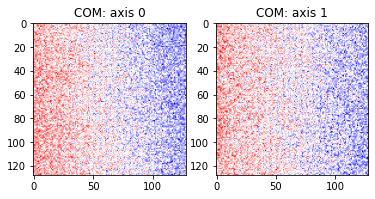

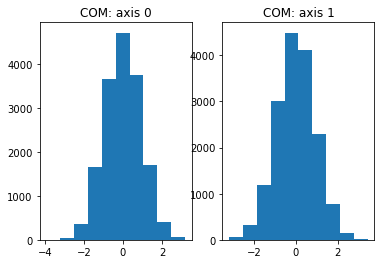

In [5]:
# Calculate the center of mass (COM) iteratively for each scan position
com2 = stim.com_sparse(vacuum_scan, crop_to=(radius, radius))
com2_median = np.median(com2, axis=(1,2))
com2_std = np.std(com2, axis=(1,2))

fg,ax = plt.subplots(1, 2)
ax[0].imshow(com2[0,]-com2_median[0], vmin=-com2_std[0]*3, vmax=com2_std[0]*3, cmap='bwr')
ax[0].set(title='COM: axis 0')
ax[1].imshow(com2[1,]-com2_median[1], vmin=-com2_std[1]*3, vmax=com2_std[1]*3, cmap='bwr')
ax[1].set(title='COM: axis 1')

fg,ax = plt.subplots(1, 2)
ax[0].hist(com2[0,].ravel() - com2_median[0])
ax[0].set(title='COM: axis 0')
ax[1].hist(com2[1,].ravel()-com2_median[1])
ax[1].set(title='COM: axis 1');

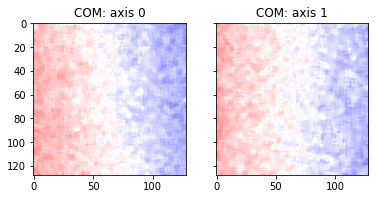

In [6]:
# Remove the outliers by median filtering
com2_filt = np.zeros_like(com2)
com2_filt[0,] = ndimage.median_filter(com2[0,], size=(5, 5))
com2_filt[1,] = ndimage.median_filter(com2[1,], size=(5, 5))

com2_median = np.median(com2_filt, axis=(1, 2))

fg,ax = plt.subplots(1, 2,sharex=True,sharey=True)
ax[0].imshow(com2_filt[0,]-com2_median[0],cmap='bwr',vmin=-3,vmax=3)
ax[0].set(title='COM: axis 0')
ax[1].imshow(com2_filt[1,]-com2_median[1],cmap='bwr',vmin=-3,vmax=3);
ax[1].set(title='COM: axis 1');

## Fit the beam motion to reduce noise
 - If the motion is linear then a plane is sufficient
 - If the motion is non-linear then use interpolation

plane fit to COM0: (array([ 6.35000000e+01,  6.35000000e+01, -3.15939076e-03]), array([-0.00217486,  0.01520988,  0.99988196]))
plane fit to COM1: (array([6.3500000e+01, 6.3500000e+01, 5.1775258e-03]), array([3.41066398e-04, 1.31027992e-02, 9.99914096e-01]))


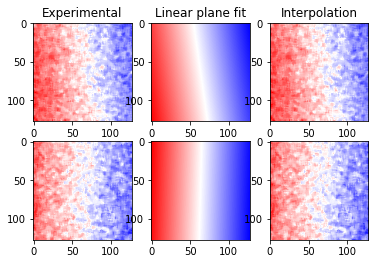

In [7]:
# Interpolate to fit the vacuum scan_shape
# This is not exactly necessary, but tests the use of interpolation for later

YY, XX = np.mgrid[0:com2.shape[1], 0:com2.shape[2]]

# Interpolation
com2_fit = np.zeros((2, *XX.shape))
com2_fit[0,:,:] = ndimage.map_coordinates(com2_filt[0,:,:], (YY.ravel(), XX.ravel()),mode='nearest').reshape(XX.shape)
com2_fit[1,:,:] = ndimage.map_coordinates(com2_filt[1,:,:], (YY.ravel(), XX.ravel()),mode='nearest').reshape(XX.shape)

com2_fit_median = np.median(com2_fit,axis=(1,2))

# Fit to a plane
planeCOM0 = planeFit(np.stack((YY, XX, com2_filt[0,]-com2_median[0])))
planeCOM1 = planeFit(np.stack((YY, XX, com2_filt[1,]-com2_median[1])))

print(f'plane fit to COM0: {planeCOM0}')
print(f'plane fit to COM1: {planeCOM1}')

normal = planeCOM0[1]
d = np.dot(-planeCOM0[0], normal)
# calculate corresponding z
z0 = (-normal[0]*YY - normal[1]*XX - d)/normal[2]

normal = planeCOM1[1]
d = np.dot(-planeCOM1[0], normal)
# calculate corresponding z
z1 = (-normal[0]*YY - normal[1]*XX - d)/normal[2]

# Plot everything together
fg,ax = plt.subplots(2, 3)
ax[0, 0].imshow(com2_filt[0,],cmap='bwr')
ax[0, 0].set(title='Experimental')
ax[0, 1].imshow(z0, cmap='bwr')
ax[0, 1].set(title='Linear plane fit')
ax[1, 0].imshow(com2_filt[1,],cmap='bwr')
ax[1, 1].imshow(z1, cmap='bwr')
ax[0, 2].imshow(com2_fit[0,]-com2_fit_median[0], cmap='bwr')
ax[1, 2].imshow(com2_fit[1,]-com2_fit_median[1], cmap='bwr')
ax[0, 2].set(title='Interpolation');

## Remove shifts from the vacuum scan to test the fit
 - Choose the method below according to the type of shift you want to correct

[Text(0.5, 1.0, 'Summed centered data')]

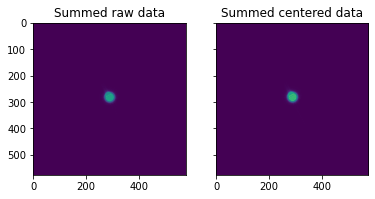

In [8]:
# Test centering on the vacuum scan itself
method = 'interp' # choose plane or interp

if method == 'interp':
    scan_origin0 = com2_fit[0,]
    scan_origin1 = com2_fit[1,]
elif method == 'plane':
    scan_origin0 = z0
    scan_origin1 = z1
scan_origin0_round = np.round(scan_origin0).astype(np.int32) - int(scan_origin0.mean())
scan_origin1_round = np.round(scan_origin1).astype(np.int32) - int(scan_origin1.mean())

# Ensure the data sets are the same size
assert vacuum_scan.data.shape[0] == scan_origin0_round.ravel().shape[0]

centered = np.empty_like(vacuum_scan.data)
for ii, (eev, x, y) in enumerate(zip(vacuum_scan.data, scan_origin0_round.ravel(), scan_origin1_round.ravel())):
    for jj, ev in enumerate(eev):
        evx, evy = np.unravel_index(ev, vacuum_scan.frame_shape)
        evx_centered = evx - y # need to flip x and y
        evy_centered = evy - x

        # Some events will get pushed off the detector by the shift. Remove them
        keep = (evx_centered < vacuum_scan.frame_shape[0]) & (evx_centered >= 0) & (evy_centered < vacuum_scan.frame_shape[1]) & (evy_centered >= 0)
        evx_centered = evx_centered[keep]
        evy_centered = evy_centered[keep]

        centered[ii, jj] = np.ravel_multi_index((evx_centered,evy_centered), vacuum_scan.frame_shape)

vacuum_scan_centered = stio.SparseArray(centered, vacuum_scan.scan_shape, vacuum_scan.frame_shape)

dp = vacuum_scan.sum(axis=(0,1))
dp2 = vacuum_scan_centered.sum(axis=(0,1))

fg,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].imshow(dp)
ax[0].set(title='Summed raw data')
ax[1].imshow(dp2)
ax[1].set(title='Summed centered data')

In [9]:
# Save the centered vacuum scan to a stempy dataset
out_name = fname.with_name('data_scan{}_th{}_electrons_centered.h5'.format(scan_num,threshold))
vacuum_scan_centered.write_to_hdf5(out_name)
print(out_name)

/mnt/nvme1/percius/sparse_Si/data_scan156_th4.5_electrons_centered.h5


# Remove beam shift from an experimental data set

File: /mnt/nvme1/percius/sparse_Si/data_scan155_th4.5_electrons.h5
Initial scan dimensions = (128, 128)


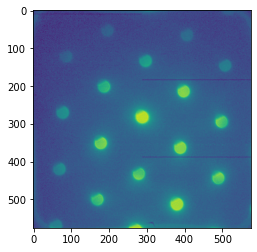

In [10]:
# Load a sparse vacuum 4D camera data set 
scan_num = 155
threshold = 4.5
scan_id = 0
# data_dir = Path('2021.10.01')

fname = Path('/mnt/nvme1/percius/sparse_Si/data_scan{}_th{}_electrons.h5'.format(scan_num, threshold))

# Load the data
experiment = stio.SparseArray.from_hdf5(fname)
experiment = experiment[:,:-1,:,:] # remove flyback

print('File: {}'.format(fname))
print('Initial scan dimensions = {}'.format(experiment.scan_shape))

fg,ax = plt.subplots(1,1)
ax.imshow(experiment[::5,::5].sum(axis=(0,1)), norm=PowerNorm(0.25));

## Generate shift correction for the experimental data set
 - the same method is used (plane or interp)
 - the experimental data set can have any real space scan shape relative to the vacuum data  set

Using method interp


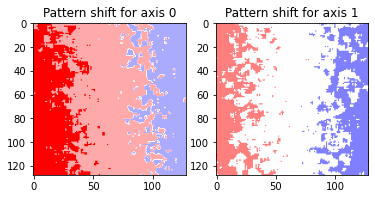

In [11]:
print(f'Using method {method}')

# Generate points on the plane to fit the experiment scan_shape
factor = (experiment.scan_shape[0] / vacuum_scan.scan_shape[0],
          experiment.scan_shape[1] / vacuum_scan.scan_shape[1])

# Generate positions between vacuum positions
YY, XX = np.mgrid[0:experiment.scan_shape[1], 0:experiment.scan_shape[0]]
YY = YY.astype('<f4') / factor[1]
XX = XX.astype('<f4') / factor[0]

if method == 'interp':
    
    com2_fit = np.zeros((2, *XX.shape))
    com2_fit[0,:,:] = ndimage.map_coordinates(com2_filt[0,:,:], (YY.ravel(), XX.ravel()),mode='nearest').reshape(XX.shape)
    com2_fit[1,:,:] = ndimage.map_coordinates(com2_filt[1,:,:], (YY.ravel(), XX.ravel()),mode='nearest').reshape(XX.shape)

    com2_fit_median = np.median(com2_fit,axis=(1,2))

    z0 = com2_fit[0,:,:]
    z1 = com2_fit[1,:,:]
elif method == 'plane':
    normal = planeCOM0[1]
    d = np.dot(-planeCOM0[0], normal)
    # calculate corresponding z
    z0 = (-normal[0]*YY - normal[1]*XX - d)/normal[2]

    normal = planeCOM1[1]
    d = np.dot(-planeCOM1[0], normal)
    # calculate corresponding z
    z1 = (-normal[0]*YY - normal[1]*XX - d)/normal[2]
else:
    print('unknown method. Choose interp or plane.')
    
# Round to integers
z0_round = np.round(z0 - z0.mean()).astype(np.int64)
z1_round = np.round(z1 - z1.mean()).astype(np.int64)

# Interpolated data must match experimetnal data shape
assert experiment.data.shape[0] == z0_round.ravel().shape[0]
assert experiment.data.shape[0] == z1_round.ravel().shape[0]

fg,ax = plt.subplots(1,2)
ax[0].imshow(z0_round,cmap='bwr')
ax[1].imshow(z1_round,cmap='bwr')
ax[0].set(title='Pattern shift for axis 0')
ax[1].set(title='Pattern shift for axis 1');

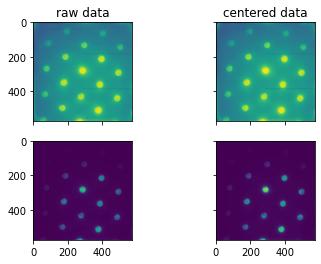

In [12]:
# Use the fitted plane from the vacuum scan to shift the events

centered = np.empty_like(experiment.data)
for ii, (eev, x, y) in enumerate(zip(experiment.data, z0_round.ravel(), z1_round.ravel())):
    for jj, ev in enumerate(eev):
        evx, evy = np.unravel_index(ev, experiment.frame_shape)
        evx_centered = evx - y # need to flip x and y
        evy_centered = evy - x

        # Some events will get pushed off the detector by the shift. Remove them
        keep = (evx_centered < experiment.frame_shape[0]) & (evx_centered >= 0) & (evy_centered < experiment.frame_shape[1]) & (evy_centered >= 0)
        evx_centered = evx_centered[keep]
        evy_centered = evy_centered[keep]

        centered[ii, jj] = np.ravel_multi_index((evx_centered,evy_centered), experiment.frame_shape)

experiment_centered = stio.SparseArray(centered, experiment.scan_shape, experiment.frame_shape)

dp = stim.calculate_sum_sparse(experiment.data, experiment.frame_shape)
dp2 = stim.calculate_sum_sparse(experiment_centered.data, experiment_centered.frame_shape)

dp = experiment.sum(axis=(0, 1))
dp2 = experiment_centered.sum(axis=(0,1))

fg,ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax[0, 0].imshow(dp, norm=LogNorm())
ax[0, 1].imshow(dp2, norm=LogNorm())
ax[0, 0].set(title='raw data')
ax[1, 0].imshow(dp)
ax[1, 1].imshow(dp2)
ax[0, 1].set(title='centered data');

In [13]:
# Save to a stempy dataset
out_name = fname.with_name('data_scan{}_th{}_electrons_centered.h5'.format(scan_num,threshold))
experiment_centered.write_to_hdf5(out_name)
print(out_name)

/mnt/nvme1/percius/sparse_Si/data_scan155_th4.5_electrons_centered.h5
